# Headers

In [4]:
import pandas as pd
from main import *


In [5]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from pytorch_lightning import Trainer
from pytorch_forecasting.models import TemporalFusionTransformer

import torch

In [6]:
import pandas as pd
import numpy as np
import torch

import pytorch_lightning as pl
from torch.utils.data import DataLoader

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss

pl.seed_everything(42)
torch.set_float32_matmul_precision("medium")

Global seed set to 42


# Data

##  Data Cleaning

In [7]:
group_cols = ["REGION", "FABRIC_TYPE", "SEASON_CONSOLIDATION",]

In [ ]:
df = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/snowflake_v5_pre_ts.csv')
df = df[~df['SALES_ORG_NAME'].isin(['47 Japan','47 New Zealand','47 UK','47 Australia'])]
# Drop unnecessary columns


In [ ]:
df['SPORT'].unique()

array(['BASEBALL', 'FOOTBALL', 'NONE', 'COLLEGE', 'ENTERTAINMENT',
       'COBRANDED RACING', 'BASKETBALL', 'HOCKEY', 'COBRANDED BASEBALL',
       'COBRANDED BASKETBALL', 'GOLF', 'RUGBY', 'SOCCER', 'RACING', nan,
       'COBRANDED NON LICENSED', 'COBRANDED FOOTBALL', 'TENNIS',
       'ANIMATED CHARACTER', 'COBRANDED CORE', 'WATER SPORTS',
       'WRESTLING', 'LACROSSE', 'E SPORT', 'COBRANDED COLLEGE',
       'COBRANDED HOCKEY', 'CRICKET', 'CYCLING', 'BOXING', 'HANDBALL',
       'SNOWSPORTS', 'COBRANDED SOCCER', 'VOLLEYBALL', 'SOFTBALL',
       'GAELIC FOOTBALL'], dtype=object)

In [ ]:
print(df['FABRIC_TYPE'].unique())
df = df[df['FABRIC_TYPE'].isin(['Wovens','Knits'])]
df.head()

['Wovens' 'Other' 'Knits' 'Polyester']


,PO_CREATED_DATE,REGION,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,20231003,Japan,Japan,Wovens,Custom,72
1,20231003,Japan,Japan,Wovens,Custom,72
2,20231109,Emerging Markets,New Zealand,Wovens,Program,80
3,20231103,North America,United States,Wovens,Program,1
4,20231103,North America,United States,Wovens,Program,1


In [ ]:
top_regions = (
    df.groupby(['REGION','SALES_ORG_NAME','FABRIC_TYPE'])['ORDERED_QUANTITY']
    .count()
)

print("Top Regions:")
print(top_regions)


Top Regions:
REGION            SALES_ORG_NAME      FABRIC_TYPE
EMEA              EMEA                Knits           152110
                                      Wovens          388721
                  EMEA Web            Wovens               1
                  German              Knits              412
                                      Wovens             797
Emerging Markets  Australia           Knits            13697
                                      Wovens           81082
                  China               Knits             1297
                                      Wovens            5075
                  Latin America       Knits            21953
                                      Wovens          100730
                  Mexico              Knits            23460
                                      Wovens           37552
                  NEC China Shanghai  Knits            13491
                                      Wovens           23519
                  New 

In [ ]:
top_sales_org_name = (
    df.groupby('SALES_ORG_NAME')['ORDERED_QUANTITY']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

print("Top Sales Org Name:")
print(top_sales_org_name)


Top Sales Org Name:
SALES_ORG_NAME
United States     3037269
EMEA               540831
5th & Ocean        275242
Southeast Asia     171694
Canada             141863
Japan              123381
Latin America      122683
Australia           94779
South Korea         79809
Mexico              61012
Name: ORDERED_QUANTITY, dtype: int64


## Choose Data

In [ ]:
df_na = df[df['REGION'] == 'North America']
df_na.head()

,PO_CREATED_DATE,REGION,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
3,20231103,North America,United States,Wovens,Program,1
4,20231103,North America,United States,Wovens,Program,1
5,20231025,North America,United States,Wovens,Custom,2
6,20231025,North America,United States,Wovens,Custom,27
9,20231024,North America,United States,Wovens,Custom,864


# Model Prep US

## Data Prep

In [360]:
df_main_us['PO_CREATED_DATE'] = pd.to_datetime(df_main_us['PO_CREATED_DATE'], format='%Y%m%d')
df_main_us = df_main_us[(df_main_us['PO_CREATED_DATE'] >= '2009-01-01') & (df_main_us['PO_CREATED_DATE'] < '2026-01-01')]

In [361]:
df_main
(df_main_us.tail())

,PO_CREATED_DATE,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
7742597,2024-07-26,United States,Wovens,Program,1
7742599,2024-08-01,United States,Knits,Program,1
7742602,2022-01-26,United States,Wovens,Custom,12
7742603,2022-02-01,United States,Knits,Custom,36
7742607,2010-09-08,United States,Wovens,Custom,30


In [362]:
df_main_us = df_main_us.drop(columns=['SALES_ORG_NAME'])

In [363]:
print(df_main_us.head())

  PO_CREATED_DATE FABRIC_TYPE SEASON_CONSOLIDATION  ORDERED_QUANTITY
3      2023-11-03      Wovens              Program                 1
4      2023-11-03      Wovens              Program                 1
5      2023-10-25      Wovens               Custom                 2
6      2023-10-25      Wovens               Custom                27
9      2023-10-24      Wovens               Custom               864


In [364]:
top_sales_org_name = (
    df_main_us.groupby(['FABRIC_TYPE','SEASON_CONSOLIDATION'])['ORDERED_QUANTITY']
    .count()
    .sort_values(ascending=False)
)

print("Top Sales Org Name:")
print(top_sales_org_name)


Top Sales Org Name:
FABRIC_TYPE  SEASON_CONSOLIDATION
Wovens       Custom                  1581820
             Program                  653050
Knits        Program                  310163
             Custom                   183921
Wovens       Stock                     52483
Knits        Stock                      3410
Name: ORDERED_QUANTITY, dtype: int64


In [365]:
df = df_main_us[(df_main_us['PO_CREATED_DATE'] >= '2010-01-01') & (df_main_us['PO_CREATED_DATE'] < '2026-01-01')]
df['DATE'] = df['PO_CREATED_DATE'].dt.to_period('M').dt.to_timestamp()
df = df.drop(columns=['PO_CREATED_DATE'])
print(df.tail())

        FABRIC_TYPE SEASON_CONSOLIDATION  ORDERED_QUANTITY       DATE
7742597      Wovens              Program                 1 2024-07-01
7742599       Knits              Program                 1 2024-08-01
7742602      Wovens               Custom                12 2022-01-01
7742603       Knits               Custom                36 2022-02-01
7742607      Wovens               Custom                30 2010-09-01


/var/folders/wn/f9dqwf512q52fzs0t0yk_4jw0000gn/T/ipykernel_143/87738706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATE'] = df['PO_CREATED_DATE'].dt.to_period('M').dt.to_timestamp()


In [366]:
df_ts = df.groupby(['DATE','FABRIC_TYPE','SEASON_CONSOLIDATION'])['ORDERED_QUANTITY'].sum().reset_index()


print("Top Sales Org Name:")
print(df_ts.head())


Top Sales Org Name:
        DATE FABRIC_TYPE SEASON_CONSOLIDATION  ORDERED_QUANTITY
0 2010-01-01       Knits               Custom              9819
1 2010-01-01      Wovens               Custom           3596359
2 2010-01-01      Wovens              Program            207994
3 2010-01-01      Wovens                Stock              2148
4 2010-02-01       Knits               Custom             74568


In [367]:
cat_cols = ['FABRIC_TYPE', 'SEASON_CONSOLIDATION']


missing_dates, pairs = verify_grp_timestamps(df_ts,cat_cols)
missing_dates

,Group,Year,Missing Months
0,"(Knits, Program)",2010,"[1, 2]"
1,"(Knits, Stock)",2010,"[1, 2, 3, 4, 5, 6, 7, 8, 9]"
2,"(Knits, Stock)",2011,"[2, 5, 7, 8, 9, 10, 11, 12]"
3,"(Knits, Stock)",2012,"[1, 3, 11]"
4,"(Knits, Stock)",2013,"[8, 9, 10, 11, 12]"
5,"(Knits, Stock)",2014,"[1, 2, 3, 4, 5, 7, 9, 12]"
6,"(Knits, Stock)",2015,"[1, 2, 3, 4, 5, 7, 10, 11]"
7,"(Knits, Stock)",2016,"[1, 3, 4, 5]"
8,"(Knits, Stock)",2017,"[2, 10, 11]"
9,"(Knits, Stock)",2018,"[1, 2, 3, 4, 9, 10]"


We Decide to drop the grou Knits and Stock, as majority of the data is missing 

The Wovens and Stock missing value which is 2012 would be filled with 0 or Avg value from last year

In [368]:
df_final = df_ts[~((df_ts['FABRIC_TYPE'] == 'Knits') & (df_ts['SEASON_CONSOLIDATION'] == 'Stock'))]

In [369]:
missing_dates_df_final, pairs_final = verify_grp_timestamps(df_final,cat_cols)

In [370]:
missing_dates_df_final

,Group,Year,Missing Months
0,"(Knits, Program)",2010,"[1, 2]"
1,"(Wovens, Stock)",2010,[2]
2,"(Wovens, Stock)",2012,"[7, 11]"


In [371]:
def fill_missing_months_inplace(df, cat_cols, date_col="DATE"):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    all_filled_rows = []  # to store newly created rows

    # Step 1: group by categorical columns dynamically
    for key, group_df in df.groupby(cat_cols):
        
        # get min/max date for the group
        full_range = pd.date_range(
            start=group_df[date_col].min(),
            end=group_df[date_col].max(),
            freq="MS"
        )

        # existing dates
        existing_dates = set(group_df[date_col])

        # Step 2: find missing dates
        missing_dates = [d for d in full_range if d not in existing_dates]

        # Step 3: create rows for missing dates
        for d in missing_dates:
            new_row = {col: val for col, val in zip(cat_cols, key)}
            new_row[date_col] = d
            new_row["ORDERED_QUANTITY"] = 0  # or 0 or np.nan
            all_filled_rows.append(new_row)

    # Step 4: add missing rows to original df
    df_filled = pd.concat([df, pd.DataFrame(all_filled_rows)], ignore_index=True)

    # Step 5: sort final df
    df_filled = df_filled.sort_values(cat_cols + [date_col]).reset_index(drop=True)

    return df_filled


In [372]:
df_filled = fill_missing_months_inplace(df_final,cat_cols)


In [373]:
df_check,pairs = verify_grp_timestamps(df_filled,cat_cols)

In [376]:
df_check

,Group,Year,Missing Months
0,"(Knits, Program)",2010,"[1, 2]"


In [374]:
pairs

[('Knits', 'Custom'),
 ('Knits', 'Program'),
 ('Wovens', 'Custom'),
 ('Wovens', 'Program'),
 ('Wovens', 'Stock')]

In [378]:
df_filled = fill_missing_months_inplace(df_final,cat_cols)
df_filled

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2010-01-01,Knits,Custom,9819
1,2010-02-01,Knits,Custom,74568
2,2010-03-01,Knits,Custom,13106
3,2010-04-01,Knits,Custom,105442
4,2010-05-01,Knits,Custom,93164
...,...,...,...,...
893,2024-08-01,Wovens,Stock,40355
894,2024-09-01,Wovens,Stock,7844
895,2024-10-01,Wovens,Stock,281194
896,2024-11-01,Wovens,Stock,86093


## CatBoost

In [322]:
cat_cols = ['FABRIC_TYPE','SEASON_CONSOLIDATION']

In [323]:
df = df_filled.copy()
df.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2010-01-01,Knits,Custom,9819
1,2010-02-01,Knits,Custom,74568
2,2010-03-01,Knits,Custom,13106
3,2010-04-01,Knits,Custom,105442
4,2010-05-01,Knits,Custom,93164


In [324]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
import numpy as np

In [325]:
# Create Lags

lag_groups = [
    'FABRIC_TYPE','SEASON_CONSOLIDATION']

df_ts = df_filled.sort_values(lag_groups + ['DATE'])

for lag in [1, 2, 3, 6, 12]:
    df_ts[f'lag_{lag}'] = (
        df_ts.groupby(lag_groups)['ORDERED_QUANTITY'].shift(lag)
    )

# =============================
# 3. Rolling means (shifted)
# =============================

for window in [3, 6, 12]:
    df_ts[f'rollmean_{window}'] = (
        df_ts.groupby(lag_groups)['ORDERED_QUANTITY']
        .transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
    )

df_ts.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12
0,2010-01-01,Knits,Custom,9819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-01,Knits,Custom,74568,9819.0,NaN,NaN,NaN,NaN,9819.000000,9819.000000,9819.000000
2,2010-03-01,Knits,Custom,13106,74568.0,9819.0,NaN,NaN,NaN,42193.500000,42193.500000,42193.500000
3,2010-04-01,Knits,Custom,105442,13106.0,74568.0,9819.0,NaN,NaN,32497.666667,32497.666667,32497.666667
4,2010-05-01,Knits,Custom,93164,105442.0,13106.0,74568.0,NaN,NaN,64372.000000,50733.750000,50733.750000


In [326]:
df_ts = df_ts[df_ts['DATE'] > '2011-01-01']
df_ts.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12
13,2011-02-01,Knits,Custom,45053,35934.0,32186.0,67580.0,42311.0,74568.0,45233.333333,49089.333333,54979.250000
14,2011-03-01,Knits,Custom,34005,45053.0,35934.0,32186.0,75899.0,13106.0,37724.333333,49546.333333,52519.666667
15,2011-04-01,Knits,Custom,71380,34005.0,45053.0,35934.0,40626.0,105442.0,38330.666667,42564.000000,54261.250000
16,2011-05-01,Knits,Custom,56011,71380.0,34005.0,45053.0,67580.0,93164.0,50146.000000,47689.666667,51422.750000
17,2011-06-01,Knits,Custom,114097,56011.0,71380.0,34005.0,32186.0,6350.0,53798.666667,45761.500000,48326.666667


In [327]:
# =============================
# 4. Seasonality
# =============================

df_ts['month'] = df_ts['DATE'].dt.month
df_ts['month_sin'] = np.sin(2 * np.pi * df_ts['month'] / 12)
df_ts['month_cos'] = np.cos(2 * np.pi * df_ts['month'] / 12)
#df_ts['quarter'] = df_ts['DATE'].dt.quarter

df_ts['ORDERED_QUANTITY_log'] = np.log1p(df_ts['ORDERED_QUANTITY'])

In [328]:
# =============================
# 6. Train/Test Split
# =============================

train = df_ts[df_ts['DATE'] < '2025-01-01']
test  = df_ts[(df_ts['DATE'] >= '2025-01-01') & 
                   (df_ts['DATE'] < '2026-01-01')]

drop_cols = ['ORDERED_QUANTITY', 'ORDERED_QUANTITY_log', 'DATE']
X_train = train.drop(columns=drop_cols)
y_train = train['ORDERED_QUANTITY_log']

X_test = test.drop(columns=drop_cols)
y_test = np.expm1(test['ORDERED_QUANTITY_log'])



In [331]:
# =============================
# 7. Identify categorical columns
# =============================

cat_cols = X_train.select_dtypes(include='object').columns.tolist()
cat_cols

['FABRIC_TYPE', 'SEASON_CONSOLIDATION']

In [332]:
# =============================
# 8. Train CatBoost
# =============================

train_dir = "/Volumes/Kaam-Dhanda/NewEra/catboost_info"
model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.05,
    depth=10,
    loss_function='MAE',
    l2_leaf_reg=3,
    random_seed=42,
    task_type='CPU',   # change to GPU if you have one
    verbose=100,
    train_dir=train_dir
)

train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool  = Pool(X_test, cat_features=cat_cols)

model.fit(train_pool)

0:	learn: 1.3168490	total: 31.3ms	remaining: 46.8s
100:	learn: 0.3860957	total: 395ms	remaining: 5.47s
200:	learn: 0.2122151	total: 820ms	remaining: 5.3s
300:	learn: 0.1328933	total: 1.22s	remaining: 4.87s
400:	learn: 0.0871599	total: 1.63s	remaining: 4.48s
500:	learn: 0.0661131	total: 2s	remaining: 3.98s
600:	learn: 0.0495784	total: 2.37s	remaining: 3.54s
700:	learn: 0.0398094	total: 2.73s	remaining: 3.11s
800:	learn: 0.0321072	total: 3.09s	remaining: 2.69s
900:	learn: 0.0259433	total: 3.45s	remaining: 2.29s
1000:	learn: 0.0217247	total: 3.81s	remaining: 1.9s
1100:	learn: 0.0183021	total: 4.17s	remaining: 1.51s
1200:	learn: 0.0163424	total: 4.57s	remaining: 1.14s
1300:	learn: 0.0141082	total: 4.96s	remaining: 759ms
1400:	learn: 0.0118139	total: 5.38s	remaining: 380ms
1499:	learn: 0.0103034	total: 5.75s	remaining: 0us


In [333]:


# =============================
# 9. Predict
# =============================

y_pred_log = model.predict(test_pool)
y_pred = np.expm1(y_pred_log)
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)
# =============================
# 10. Metrics
# =============================


mae = np.mean(np.abs(y_test - y_pred))
wape = np.sum(np.abs(y_test - y_pred)) / np.sum(y_test)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))

print("MAE:", mae)
print("RMSE:", rmse)
print("WAPE:", wape * 100)
print("Accuracy:", 100 - wape * 100)


MAE: 427540.81481481483
RMSE: 663019.1520856749
WAPE: 56.432883691209376
Accuracy: 43.567116308790624


In [334]:
y_pred = pd.DataFrame(y_pred)

In [335]:
plot_df = test.copy().reset_index().drop(columns=['index'])
plot_df.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12,month,month_sin,month_cos,ORDERED_QUANTITY_log
0,2025-01-01,Knits,Custom,178037,295878.0,47060.0,154505.0,273166.0,492754.0,165814.333333,221453.500000,351170.750000,1,0.500000,8.660254e-01,12.089752
1,2025-02-01,Knits,Custom,289565,178037.0,295878.0,47060.0,309222.0,221276.0,173658.333333,205598.666667,324944.333333,2,0.866025,5.000000e-01,12.576139
2,2025-03-01,Knits,Custom,238873,289565.0,178037.0,295878.0,248890.0,458416.0,254493.333333,202322.500000,330635.083333,3,1.000000,6.123234e-17,12.383691
3,2025-04-01,Knits,Custom,750793,238873.0,289565.0,178037.0,154505.0,317406.0,235491.666667,200653.000000,312339.833333,4,0.866025,-5.000000e-01,13.528887
4,2025-05-01,Knits,Custom,214204,750793.0,238873.0,289565.0,47060.0,882522.0,426410.333333,300034.333333,348455.416667,5,0.500000,-8.660254e-01,12.274689


In [336]:
len(plot_df) == len(y_pred)

True

In [337]:
plot_df['y_pred'] = y_pred
plot_df.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12,month,month_sin,month_cos,ORDERED_QUANTITY_log,y_pred
0,2025-01-01,Knits,Custom,178037,295878.0,47060.0,154505.0,273166.0,492754.0,165814.333333,221453.500000,351170.750000,1,0.500000,8.660254e-01,12.089752,431605
1,2025-02-01,Knits,Custom,289565,178037.0,295878.0,47060.0,309222.0,221276.0,173658.333333,205598.666667,324944.333333,2,0.866025,5.000000e-01,12.576139,452898
2,2025-03-01,Knits,Custom,238873,289565.0,178037.0,295878.0,248890.0,458416.0,254493.333333,202322.500000,330635.083333,3,1.000000,6.123234e-17,12.383691,326054
3,2025-04-01,Knits,Custom,750793,238873.0,289565.0,178037.0,154505.0,317406.0,235491.666667,200653.000000,312339.833333,4,0.866025,-5.000000e-01,13.528887,427929
4,2025-05-01,Knits,Custom,214204,750793.0,238873.0,289565.0,47060.0,882522.0,426410.333333,300034.333333,348455.416667,5,0.500000,-8.660254e-01,12.274689,208073


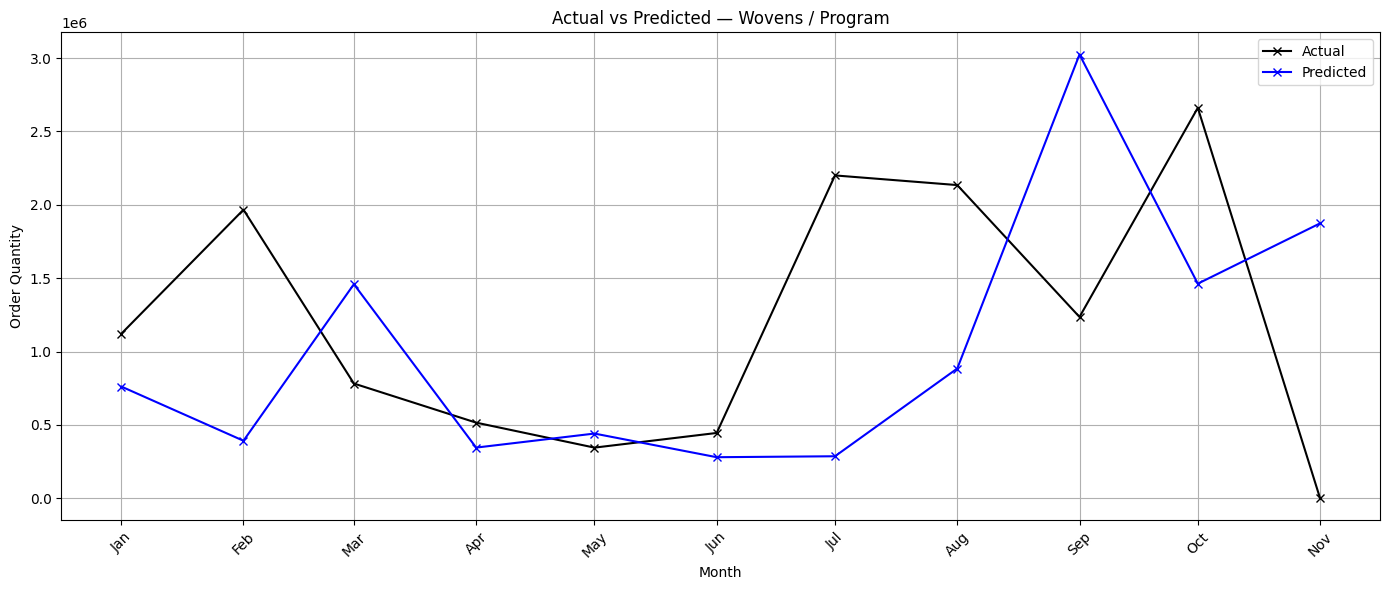

In [340]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fabrics = 'Wovens'
season = 'Program'

df_pivot = plot_df[(plot_df['FABRIC_TYPE'] == fabrics) &
                   (plot_df['SEASON_CONSOLIDATION'] == season)]

df_pivot = df_pivot.sort_values("DATE")

plt.figure(figsize=(14,6))

plt.plot(df_pivot['DATE'], df_pivot['ORDERED_QUANTITY'], 
         'x-',label="Actual", color="black")
plt.plot(df_pivot['DATE'], df_pivot['y_pred'], 
         'x-',label="Predicted", color="blue")

# ★ Show month names
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))   # ← Month name + Year
plt.xticks(rotation=45)

plt.title(f"Actual vs Predicted — {fabrics} / {season}")
plt.xlabel("Month")
plt.ylabel("Order Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [339]:
calculate_metrics(test,y_pred,pairs,cat_cols)

,group,MAE,RMSE,WAPE,COUNT
0,"(Knits, Custom)",129521.09,161575.92,42.77,11
1,"(Knits, Program)",138841.70,157875.67,65.09,10
2,"(Wovens, Custom)",628524.45,745398.01,36.31,11
3,"(Wovens, Program)",1005794.73,1224556.96,82.52,11
4,"(Wovens, Stock)",208777.18,232562.22,76.63,11


## CatBoost - Quantiles

In [383]:
cat_cols = ['FABRIC_TYPE','SEASON_CONSOLIDATION']

In [384]:
df = df_filled.copy()
df.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2010-01-01,Knits,Custom,9819
1,2010-02-01,Knits,Custom,74568
2,2010-03-01,Knits,Custom,13106
3,2010-04-01,Knits,Custom,105442
4,2010-05-01,Knits,Custom,93164


In [385]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
import numpy as np

In [386]:
# Create Lags

lag_groups = [
    'FABRIC_TYPE','SEASON_CONSOLIDATION']

df_ts = df_filled.sort_values(lag_groups + ['DATE'])

for lag in [1, 2, 3, 6, 12]:
    df_ts[f'lag_{lag}'] = (
        df_ts.groupby(lag_groups)['ORDERED_QUANTITY'].shift(lag)
    )

# =============================
# 3. Rolling means (shifted)
# =============================

for window in [3, 6, 12]:
    df_ts[f'rollmean_{window}'] = (
        df_ts.groupby(lag_groups)['ORDERED_QUANTITY']
        .transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
    )

df_ts.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12
0,2010-01-01,Knits,Custom,9819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-01,Knits,Custom,74568,9819.0,NaN,NaN,NaN,NaN,9819.000000,9819.000000,9819.000000
2,2010-03-01,Knits,Custom,13106,74568.0,9819.0,NaN,NaN,NaN,42193.500000,42193.500000,42193.500000
3,2010-04-01,Knits,Custom,105442,13106.0,74568.0,9819.0,NaN,NaN,32497.666667,32497.666667,32497.666667
4,2010-05-01,Knits,Custom,93164,105442.0,13106.0,74568.0,NaN,NaN,64372.000000,50733.750000,50733.750000


In [387]:
df_ts = df_ts[df_ts['DATE'] >= '2011-01-01']
df_ts.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12
12,2011-01-01,Knits,Custom,35934,32186.0,67580.0,40626.0,72585.0,9819.0,46797.333333,55197.833333,52803.000000
13,2011-02-01,Knits,Custom,45053,35934.0,32186.0,67580.0,42311.0,74568.0,45233.333333,49089.333333,54979.250000
14,2011-03-01,Knits,Custom,34005,45053.0,35934.0,32186.0,75899.0,13106.0,37724.333333,49546.333333,52519.666667
15,2011-04-01,Knits,Custom,71380,34005.0,45053.0,35934.0,40626.0,105442.0,38330.666667,42564.000000,54261.250000
16,2011-05-01,Knits,Custom,56011,71380.0,34005.0,45053.0,67580.0,93164.0,50146.000000,47689.666667,51422.750000


In [388]:
# =============================
# 4. Seasonality
# =============================

df_ts['month'] = df_ts['DATE'].dt.month
df_ts['month_sin'] = np.sin(2 * np.pi * df_ts['month'] / 12)
df_ts['month_cos'] = np.cos(2 * np.pi * df_ts['month'] / 12)
df_ts['quarter'] = df_ts['DATE'].dt.quarter

df_ts['ORDERED_QUANTITY_log'] = np.log1p(df_ts['ORDERED_QUANTITY'])

In [389]:
# =============================
# 6. Train/Test Split
# =============================

train = df_ts[df_ts['DATE'] < '2024-01-01']
test  = df_ts[(df_ts['DATE'] >= '2024-01-01') & 
                   (df_ts['DATE'] < '2025-01-01')]

drop_cols = ['ORDERED_QUANTITY', 'ORDERED_QUANTITY_log', 'DATE']
X_train = train.drop(columns=drop_cols)
y_train = train['ORDERED_QUANTITY_log']

X_test = test.drop(columns=drop_cols)
y_test = np.expm1(test['ORDERED_QUANTITY_log'])



In [390]:
y_train

12     10.489467
13     10.715617
14     10.434292
15     11.175787
16     10.933321
         ...    
881    12.003179
882     5.796058
883    11.742154
884    12.074688
885    10.119929
Name: ORDERED_QUANTITY_log, Length: 780, dtype: float64

In [391]:
# =============================
# 7. Identify categorical columns
# =============================

cat_cols = X_train.select_dtypes(include='object').columns.tolist()
cat_cols

['FABRIC_TYPE', 'SEASON_CONSOLIDATION']

In [392]:
# =============================
# 8. Train CatBoost
# =============================

from catboost import CatBoostRegressor, Pool

train_dir = "/Volumes/Kaam-Dhanda/NewEra/catboost_info"
def train_quantile_model(alpha, X_train, y_train, cat_cols):
    model = CatBoostRegressor(
        iterations=1500,
        learning_rate=0.05,
        depth=10,
        loss_function=f'Quantile:alpha={alpha}',
        random_seed=42,
        verbose=100,
        train_dir=train_dir
    )
    
    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    model.fit(train_pool)
    return model

In [393]:
model_p10 = train_quantile_model(0.10, X_train, y_train, cat_cols)
model_p50 = train_quantile_model(0.50, X_train, y_train, cat_cols)  # median
model_p90 = train_quantile_model(0.90, X_train, y_train, cat_cols)

0:	learn: 0.3502469	total: 42.9ms	remaining: 1m 4s
100:	learn: 0.0751201	total: 430ms	remaining: 5.95s
200:	learn: 0.0490479	total: 781ms	remaining: 5.05s
300:	learn: 0.0401126	total: 1.21s	remaining: 4.8s
400:	learn: 0.0324116	total: 1.59s	remaining: 4.37s
500:	learn: 0.0273649	total: 1.97s	remaining: 3.92s
600:	learn: 0.0234622	total: 2.43s	remaining: 3.64s
700:	learn: 0.0203951	total: 2.81s	remaining: 3.21s
800:	learn: 0.0182033	total: 3.19s	remaining: 2.78s
900:	learn: 0.0157334	total: 3.57s	remaining: 2.38s
1000:	learn: 0.0141071	total: 3.95s	remaining: 1.97s
1100:	learn: 0.0133091	total: 4.32s	remaining: 1.57s
1200:	learn: 0.0126283	total: 4.7s	remaining: 1.17s
1300:	learn: 0.0119263	total: 5.06s	remaining: 774ms
1400:	learn: 0.0109664	total: 5.45s	remaining: 385ms
1499:	learn: 0.0105382	total: 5.82s	remaining: 0us
0:	learn: 0.6672528	total: 4.31ms	remaining: 6.46s
100:	learn: 0.1885544	total: 387ms	remaining: 5.36s
200:	learn: 0.1021696	total: 764ms	remaining: 4.94s
300:	learn: 

In [395]:
test_pool = Pool(X_test, cat_features=cat_cols)

pred_log_p10 = model_p10.predict(test_pool)
pred_log_p50 = model_p50.predict(test_pool)
pred_log_p90 = model_p90.predict(test_pool)

# Convert from log scale back to original
pred_p10 = np.expm1(pred_log_p10)
pred_p50 = np.expm1(pred_log_p50)
pred_p90 = np.expm1(pred_log_p90)

In [408]:
test.loc[:,'pred_p10'] = pred_p10.astype(int)
test.loc[:,'pred_p50'] = pred_p50.astype(int)
test.loc[:,'pred_p90'] = pred_p90.astype(int)

/var/folders/wn/f9dqwf512q52fzs0t0yk_4jw0000gn/T/ipykernel_143/2669655767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pred_p10'] = pred_p10.astype(int)
/var/folders/wn/f9dqwf512q52fzs0t0yk_4jw0000gn/T/ipykernel_143/2669655767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pred_p50'] = pred_p50.astype(int)
/var/folders/wn/f9dqwf512q52fzs0t0yk_4jw0000gn/T/ipykernel_143/2669655767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [409]:
test.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12,month,month_sin,month_cos,quarter,ORDERED_QUANTITY_log,pred_p10,pred_p50,pred_p90
168,2024-01-01,Knits,Custom,492754,226606.0,292977.0,595448.0,65273.0,494500.0,371677.000000,278299.833333,329111.750000,1,0.500000,8.660254e-01,1,13.107767,299157,322470,377019
169,2024-02-01,Knits,Custom,221276,492754.0,226606.0,292977.0,214419.0,266318.0,337445.666667,349546.666667,328966.250000,2,0.866025,5.000000e-01,1,12.307171,347069,340531,510139
170,2024-03-01,Knits,Custom,458416,221276.0,492754.0,226606.0,275076.0,561480.0,313545.333333,350689.500000,325212.750000,3,1.000000,6.123234e-17,1,13.035535,284169,473731,731860
171,2024-04-01,Knits,Custom,317406,458416.0,221276.0,492754.0,595448.0,525628.0,390815.333333,381246.166667,316624.083333,4,0.866025,-5.000000e-01,2,12.667940,199283,379105,653670
172,2024-05-01,Knits,Custom,882522,317406.0,458416.0,221276.0,292977.0,301521.0,332366.000000,334905.833333,299272.250000,5,0.500000,-8.660254e-01,2,13.690540,241246,349697,627796


In [17]:
fabrics = 'Knits'
season = 'Stock'

df_pivot = test[(test['FABRIC_TYPE'] == fabrics) &
                   (test['SEASON_CONSOLIDATION'] == season)].copy()

df_pivot = df_pivot.sort_values("DATE")

df_pivot = df_pivot[['DATE','FABRIC_TYPE','SEASON_CONSOLIDATION','ORDERED_QUANTITY','month','pred_p10','pred_p50','pred_p90']]
df_pivot['lower'] = df_pivot[['pred_p10', 'pred_p50', 'pred_p90']].min(axis=1)
df_pivot['upper'] = df_pivot[['pred_p10', 'pred_p50', 'pred_p90']].max(axis=1)

df_pivot['lower'] = df_pivot['lower'].rolling(2, min_periods=1).mean()
df_pivot['upper'] = df_pivot['upper'].rolling(2, min_periods=1).mean()


df_pivot= df_pivot.drop(columns=['pred_p10','pred_p90'])

plt.figure(figsize=(14,6))

plt.plot(df_pivot['DATE'], df_pivot['ORDERED_QUANTITY'], 
         'x-',label="Actual", color="black")

plt.plot(df_pivot['DATE'], df_pivot['pred_p50'], 
         'x-',label="Predicted", color="blue")

plt.fill_between(
    df_pivot['DATE'],
    df_pivot['lower'],
    df_pivot['upper'],
    color='blue',
    alpha=0.2,
    label="80% Prediction Interval"
)

plt.legend()
plt.grid()
plt.show()


NameError: name 'test' is not defined

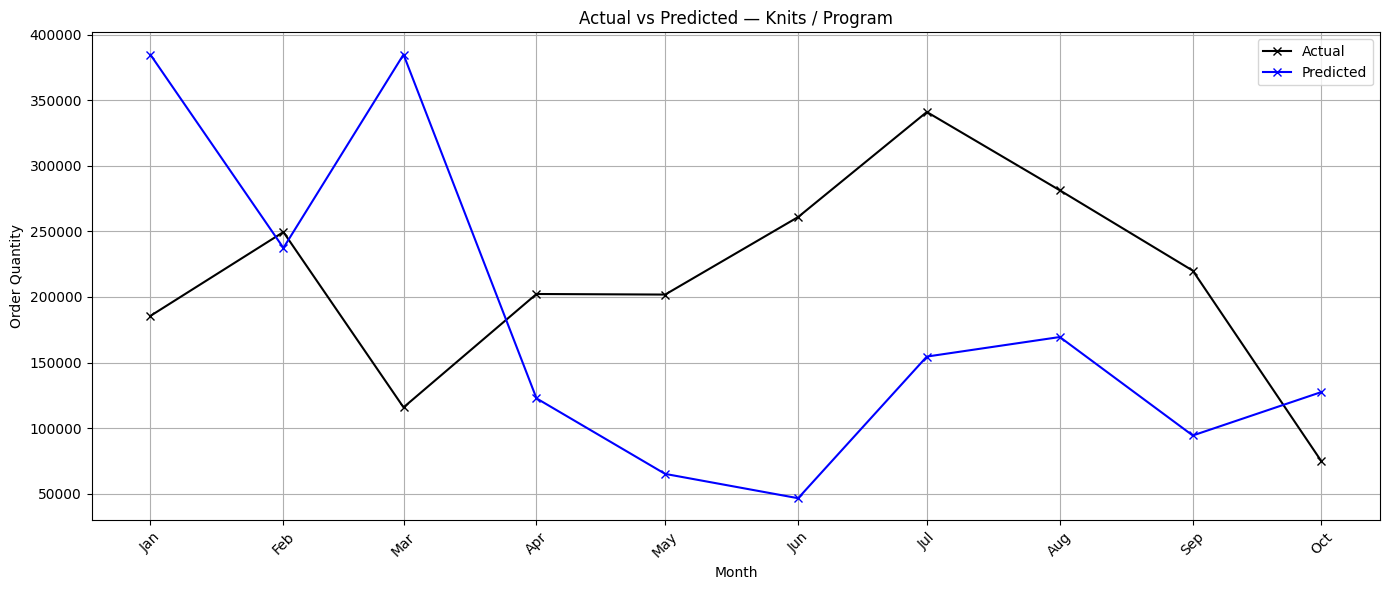

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fabrics = 'Wovens'
season = 'Program'

df_pivot = plot_df[(plot_df['FABRIC_TYPE'] == fabrics) &
                   (plot_df['SEASON_CONSOLIDATION'] == season)]

df_pivot = df_pivot.sort_values("DATE")

plt.figure(figsize=(14,6))

plt.plot(df_pivot['DATE'], df_pivot['ORDERED_QUANTITY'], 
         'x-',label="Actual", color="black")
plt.plot(df_pivot['DATE'], df_pivot['y_pred'], 
         'x-',label="Predicted", color="blue")

# ★ Show month names
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))   # ← Month name + Year
plt.xticks(rotation=45)

plt.title(f"Actual vs Predicted — {fabrics} / {season}")
plt.xlabel("Month")
plt.ylabel("Order Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [414]:
calculate_metrics(test,y_pred,pairs,cat_cols)

,group,MAE,RMSE,WAPE,COUNT
0,"(Knits, Custom)",144496.00,225083.45,41.15,12
1,"(Knits, Program)",711241.50,1110599.09,273.07,12
2,"(Wovens, Custom)",1127816.17,1446184.26,48.07,12
3,"(Wovens, Program)",927691.83,1190472.66,133.73,12
4,"(Wovens, Stock)",NaN,NaN,NaN,12


## TFT Model Training

In [31]:
pairs

[('Knits', 'Custom'),
 ('Knits', 'Program'),
 ('Wovens', 'Custom'),
 ('Wovens', 'Program'),
 ('Wovens', 'Stock')]

In [32]:
print(df_filled.head())

        DATE FABRIC_TYPE SEASON_CONSOLIDATION  ORDERED_QUANTITY
0 2020-01-01       Knits               Custom            316844
1 2020-02-01       Knits               Custom            509592
2 2020-03-01       Knits               Custom            286176
3 2020-04-01       Knits               Custom             31683
4 2020-05-01       Knits               Custom            185776


In [33]:
df_filled

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2020-01-01,Knits,Custom,316844
1,2020-02-01,Knits,Custom,509592
2,2020-03-01,Knits,Custom,286176
3,2020-04-01,Knits,Custom,31683
4,2020-05-01,Knits,Custom,185776
...,...,...,...,...
295,2024-08-01,Wovens,Stock,40355
296,2024-09-01,Wovens,Stock,7844
297,2024-10-01,Wovens,Stock,281194
298,2024-11-01,Wovens,Stock,86093


In [34]:
df = df_filled.copy()

In [35]:
from sklearn.preprocessing import StandardScaler

df["time_idx"] = df.groupby(["FABRIC_TYPE", "SEASON_CONSOLIDATION"]).cumcount()
df["ORDERED_QUANTITY"] = pd.to_numeric(df["ORDERED_QUANTITY"], errors="coerce").astype(float)
# Scale the target
scaler = StandardScaler()
df['target'] = scaler.fit_transform(df[['ORDERED_QUANTITY']])

In [36]:
df.head()

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,time_idx,target
0,2020-01-01,Knits,Custom,316844.0,0,-0.534487
1,2020-02-01,Knits,Custom,509592.0,1,-0.387820
2,2020-03-01,Knits,Custom,286176.0,2,-0.557823
3,2020-04-01,Knits,Custom,31683.0,3,-0.751473
4,2020-05-01,Knits,Custom,185776.0,4,-0.634220


In [37]:
from pytorch_forecasting import TimeSeriesDataSet

# Window lengths
max_encoder_length = 36    # use past 36 months
max_prediction_length = 12  # predict next 12 months

# Training cutoff
training_cutoff = df['time_idx'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["FABRIC_TYPE","SEASON_CONSOLIDATION"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["target"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(
    training,
    df,
    predict=True,
    stop_randomization=True
)


In [38]:
print(df[['FABRIC_TYPE', 'SEASON_CONSOLIDATION']].dtypes)
print(df[['FABRIC_TYPE', 'SEASON_CONSOLIDATION']].head())
print(df[['FABRIC_TYPE', 'SEASON_CONSOLIDATION']].nunique())


FABRIC_TYPE             object
SEASON_CONSOLIDATION    object
dtype: object
  FABRIC_TYPE SEASON_CONSOLIDATION
0       Knits               Custom
1       Knits               Custom
2       Knits               Custom
3       Knits               Custom
4       Knits               Custom
FABRIC_TYPE             2
SEASON_CONSOLIDATION    3
dtype: int64


In [39]:
train_loader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_loader   = validation.to_dataloader(train=False, batch_size=32, num_workers=0)

print(len(train_loader.dataset), len(val_loader.dataset))


5 5


In [40]:
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.005,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,   # ✅ one per quantile
    loss=QuantileLoss(),  # default quantiles = 7
)



/opt/anaconda3/envs/nec10/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/opt/anaconda3/envs/nec10/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [41]:
from pytorch_lightning import Trainer

trainer = Trainer(
    max_epochs=50,
    gradient_clip_val=0.1,
    accelerator="cpu",
    logger=False  # or "gpu" if you have CUDA
)

trainer.fit(tft, train_loader, val_loader)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/nec10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/opt/anaconda3/envs/nec10/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /Volumes/Kaam-Dhanda/NewEra/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      |

/opt/anaconda3/envs/nec10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/nec10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 67.80it/s, loss=0.193, train_loss_step=0.171, val_loss=0.136, train_loss_epoch=0.171]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 51.25it/s, loss=0.193, train_loss_step=0.171, val_loss=0.136, train_loss_epoch=0.171]


In [42]:
raw_preds, index = tft.predict(
    val_loader, 
    mode="raw", 
    return_index=True
)

pred_tensor = raw_preds["prediction"]   # [B, 12, 7]
print("Index:")
print(index)
print("Pred tensor shape:", pred_tensor.shape)


Index:
   time_idx FABRIC_TYPE SEASON_CONSOLIDATION
0        48       Knits               Custom
1        48       Knits              Program
2        48      Wovens               Custom
3        48      Wovens              Program
4        48      Wovens                Stock
Pred tensor shape: torch.Size([5, 12, 7])


In [43]:
import pandas as pd
import numpy as np

# quantiles in order (default TFT)
quantiles = [0.005, 0.025, 0.165, 0.50, 0.835, 0.975, 0.995]

rows = []

for b in range(len(index)):
    group_ft  = index.iloc[b]["FABRIC_TYPE"]
    group_sea = index.iloc[b]["SEASON_CONSOLIDATION"]
    last_time = index.iloc[b]["time_idx"]

    # next forecast time_idxs
    pred_times = np.arange(last_time+1, last_time+1+pred_tensor.shape[1])

    # inverse-scale predictions
    pred_scaled = pred_tensor[b].detach().numpy()         
    pred_inv = scaler.inverse_transform(pred_scaled)

    # build rows
    for t_idx, qvals in zip(pred_times, pred_inv):
        row = {
            "time_idx": t_idx,
            "FABRIC_TYPE": group_ft,
            "SEASON_CONSOLIDATION": group_sea,
            "p50":  qvals[3],     # median
            "p10":  qvals[1],
            "p90":  qvals[5],
        }
        rows.append(row)

forecast_df = pd.DataFrame(rows)
print(forecast_df.head())


   time_idx FABRIC_TYPE SEASON_CONSOLIDATION           p50            p10  \
0        49       Knits               Custom  296494.03125  153597.984375   
1        50       Knits               Custom  287973.15625  136374.796875   
2        51       Knits               Custom  285146.78125  128259.101562   
3        52       Knits               Custom  284853.09375  124178.039062   
4        53       Knits               Custom  285597.65625  121864.726562   

           p90  
0  763967.5000  
1  767566.5625  
2  772880.5000  
3  778731.3750  
4  784606.9375  


In [44]:
from pandas.tseries.offsets import DateOffset

# 1. Map each group to its earliest date (time_idx = 0)
map_df = (
    df.groupby(["FABRIC_TYPE", "SEASON_CONSOLIDATION"])["DATE"]
      .min()
      .reset_index()
      .rename(columns={"DATE": "START_DATE"})
)

# 2. Merge map back into forecast dataframe
forecast_df = forecast_df.merge(
    map_df,
    on=["FABRIC_TYPE", "SEASON_CONSOLIDATION"],
    how="left"
)

# 3. Compute actual forecast dates using DateOffset
forecast_df["FORECAST_DATE"] = forecast_df.apply(
    lambda row: row["START_DATE"] + DateOffset(months=int(row["time_idx"])),
    axis=1
)

forecast_df.head()


,time_idx,FABRIC_TYPE,SEASON_CONSOLIDATION,p50,p10,p90,START_DATE,FORECAST_DATE
0,49,Knits,Custom,296494.03125,153597.984375,763967.5000,2020-01-01,2024-02-01
1,50,Knits,Custom,287973.15625,136374.796875,767566.5625,2020-01-01,2024-03-01
2,51,Knits,Custom,285146.78125,128259.101562,772880.5000,2020-01-01,2024-04-01
3,52,Knits,Custom,284853.09375,124178.039062,778731.3750,2020-01-01,2024-05-01
4,53,Knits,Custom,285597.65625,121864.726562,784606.9375,2020-01-01,2024-06-01


In [45]:
actual_df = df[['DATE','FABRIC_TYPE','SEASON_CONSOLIDATION','ORDERED_QUANTITY']].copy()

In [46]:
forecast_df = forecast_df.merge(
    actual_df.rename(columns={"DATE": "FORECAST_DATE"}),
    on=["FABRIC_TYPE", "SEASON_CONSOLIDATION", "FORECAST_DATE"],
    how="left"
)


In [47]:
print(forecast_df.head())

   time_idx FABRIC_TYPE SEASON_CONSOLIDATION           p50            p10  \
0        49       Knits               Custom  296494.03125  153597.984375   
1        50       Knits               Custom  287973.15625  136374.796875   
2        51       Knits               Custom  285146.78125  128259.101562   
3        52       Knits               Custom  284853.09375  124178.039062   
4        53       Knits               Custom  285597.65625  121864.726562   

           p90 START_DATE FORECAST_DATE  ORDERED_QUANTITY  
0  763967.5000 2020-01-01    2024-02-01          221276.0  
1  767566.5625 2020-01-01    2024-03-01          458416.0  
2  772880.5000 2020-01-01    2024-04-01          317406.0  
3  778731.3750 2020-01-01    2024-05-01          882522.0  
4  784606.9375 2020-01-01    2024-06-01          512954.0  


In [48]:
import matplotlib.pyplot as plt

def plot_group(fabric_type, season_value):
    """
    Plot actual vs forecast for a specific (FABRIC_TYPE, SEASON_CONSOLIDATION) group.
    """
    # Filter
    g = forecast_df[
        (forecast_df["FABRIC_TYPE"] == fabric_type) &
        (forecast_df["SEASON_CONSOLIDATION"] == season_value)
    ].sort_values("FORECAST_DATE")

    if g.empty:
        print(f"❌ No data found for group: ({fabric_type}, {season_value})")
        return
    
    plt.figure(figsize=(14, 6))

    # Actual values
    plt.plot(
        g["FORECAST_DATE"],
        g["ORDERED_QUANTITY"],
        label="Actual",
        color="black",
        linewidth=2,
    )

    # p50 forecast (median)
    plt.plot(
        g["FORECAST_DATE"],
        g["p50"],
        label="Prediction (p50)",
        color="blue",
        linewidth=2,
    )

    # Uncertainty band p10–p90
    plt.fill_between(
        g["FORECAST_DATE"],
        g["p10"],
        g["p90"],
        color="blue",
        alpha=0.2,
        label="Prediction Range (p10–p90)",
    )

    plt.title(f"TFT Forecast vs Actuals — {fabric_type} | {season_value}")
    plt.xlabel("Date")
    plt.ylabel("Ordered Quantity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [49]:
plot_group("Knits", "Stock")


❌ No data found for group: (Knits, Stock)


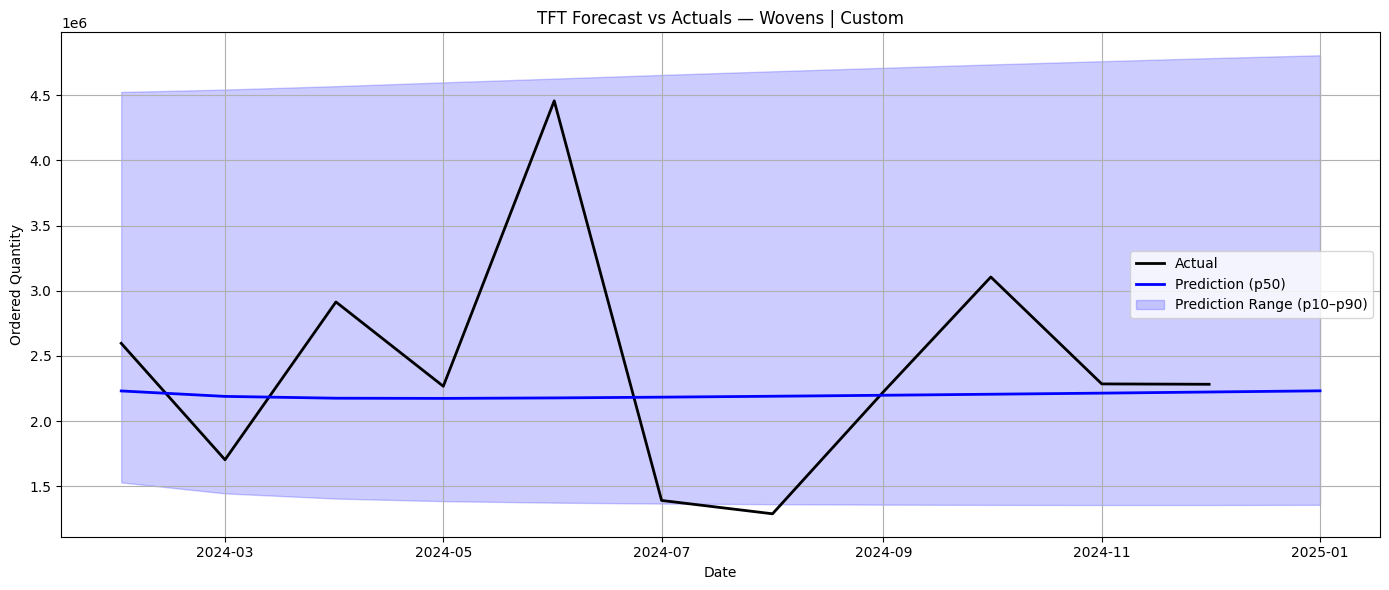

In [53]:
plot_group("Wovens", "Custom")


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Use p50 as main prediction
forecast_df["pred"] = forecast_df["p50"]

# Drop any missing rows
eval_df = forecast_df.dropna(subset=["ORDERED_QUANTITY", "pred"])

y_true = eval_df["ORDERED_QUANTITY"].values
y_pred = eval_df["pred"].values

# Metrics
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
wape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

print("📊 **Forecast Evaluation Metrics (All groups combined)**")
print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"WAPE : {wape:.2f}%")
print(f"Accuracy (1-WAPE): {100-wape:.2f}%")


📊 **Forecast Evaluation Metrics (All groups combined)**
MAE  : 299,875.99
RMSE : 507,889.00
WAPE : 40.01%
Accuracy (1-WAPE): 59.99%


In [55]:
group_mae = (
    forecast_df
    .dropna(subset=["ORDERED_QUANTITY", "p50"])
    .groupby(["FABRIC_TYPE", "SEASON_CONSOLIDATION"])
    .apply(lambda g: mean_absolute_error(g["ORDERED_QUANTITY"], g["p50"]))
)

group_mae


FABRIC_TYPE  SEASON_CONSOLIDATION
Knits        Custom                  142029.468750
             Program                 254670.726030
Wovens       Custom                  610114.931818
             Program                 397457.840909
             Stock                    95106.960760
dtype: float64

### Visualize - TFT

In [56]:
df

,DATE,FABRIC_TYPE,SEASON_CONSOLIDATION,ORDERED_QUANTITY,time_idx,target
0,2020-01-01,Knits,Custom,316844.0,0,-0.534487
1,2020-02-01,Knits,Custom,509592.0,1,-0.387820
2,2020-03-01,Knits,Custom,286176.0,2,-0.557823
3,2020-04-01,Knits,Custom,31683.0,3,-0.751473
4,2020-05-01,Knits,Custom,185776.0,4,-0.634220
...,...,...,...,...,...,...
295,2024-08-01,Wovens,Stock,40355.0,55,-0.744875
296,2024-09-01,Wovens,Stock,7844.0,56,-0.769613
297,2024-10-01,Wovens,Stock,281194.0,57,-0.561614
298,2024-11-01,Wovens,Stock,86093.0,58,-0.710071


In [57]:
fabric = 'Wovens'
season = 'Program'
df_visual = df[(df['FABRIC_TYPE'] == fabric) & (df['SEASON_CONSOLIDATION'] == season)]
string_val = f'United States: Fabric Type: {fabric} & Season Consolidation: {season}'

/Volumes/Kaam-Dhanda/NewEra/main.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
/Volumes/Kaam-Dhanda/NewEra/main.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['DATE'].dt.year
/Volumes/Kaam-Dhanda/NewEra/main.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

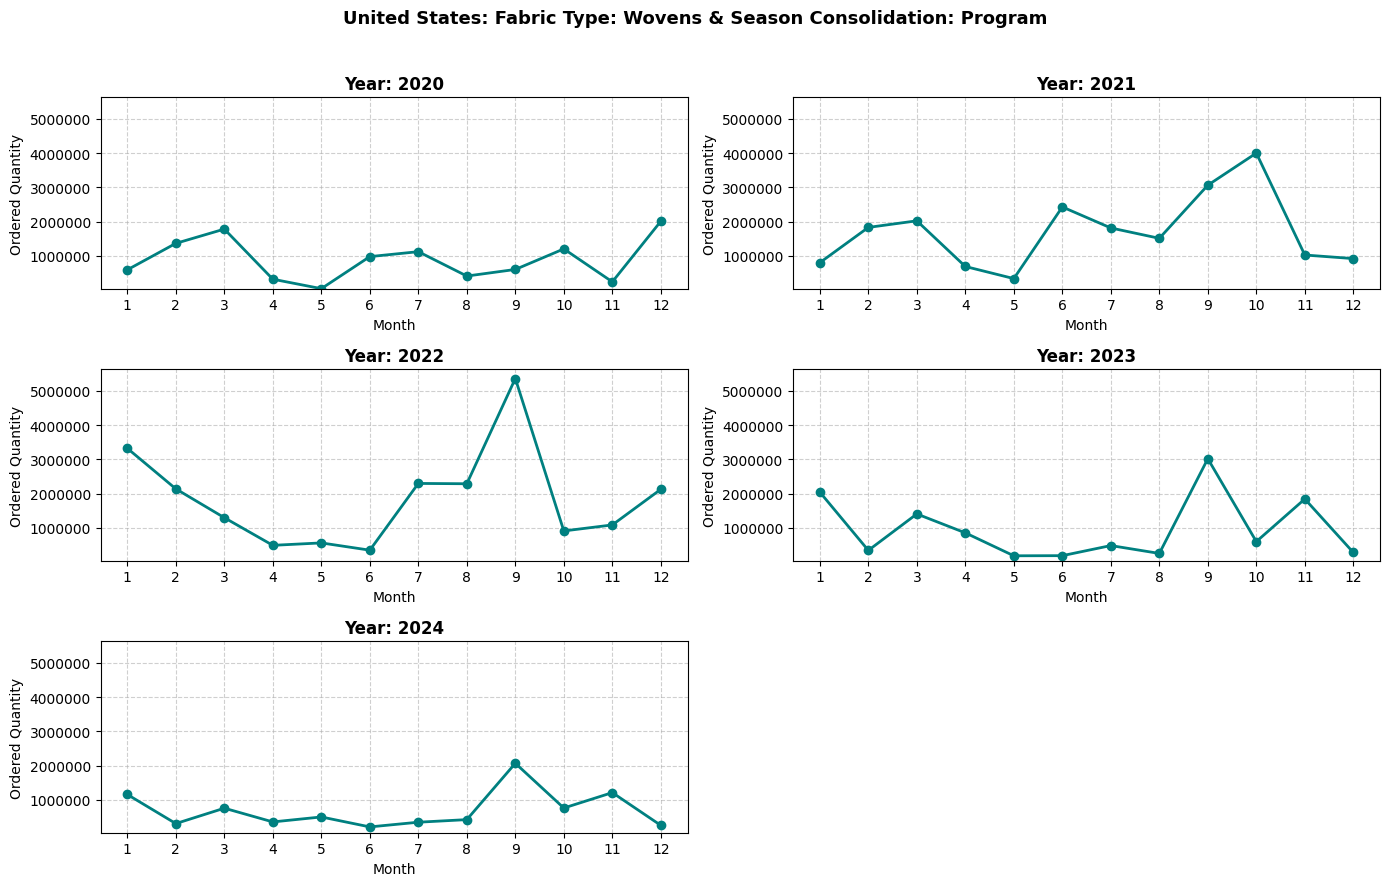

In [58]:
plot_data_by_year_standardized(df_visual, string_val)